In [1]:
#import dependencies
import pandas as pd
import numpy as np
import scanpy as sc
import os
from matplotlib.pyplot import rc_context
import sys
import warnings
import scvi
import anndata
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl #pip install kneed

Global seed set to 0


In [2]:
# Set figure parameters
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.4


In [3]:
#set up directory
# large_root = r"C:\Users\Romina\Documents\Data Science\1.PROJECTS\1.ScRnaSeq\2.MelanomaCD8\01-data"
large_root = r"..\01-data"
results_file = large_root + "\melanoma_TIL.h5ad"

In [4]:
# import matrix, obs and var
adata = sc.read('../01-data/matrix/matrix.mtx')
adata.var = pd.read_csv('../01-data/matrix/genes.tsv',index_col='gene_symbols')
adata.obs =  pd.read_csv('../01-data/matrix/barcodes.tsv',index_col='sample_name')

#import additional patient info
patient_info = pd.read_csv('../01-data/GSE120575_sample_info.csv', index_col='sample_name')

#concatenate additional patient info to adata.obs
adata.obs = pd.concat([adata.obs, patient_info], axis=1).reindex(patient_info.index)
adata

AnnData object with n_obs × n_vars = 16290 × 55737
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy'

# QC: Filtering out cells & genes

In [5]:
# data processing steps by authors (already done in adata):
# - FASTQ files were aligned to the NCBI Human Reference Genome Build GRCh37 (hg19) using STAR
# - Expression levels were quantified as Transcripts Per Million (TPM) and were computed by the RSEM tool. Data were annotated using GENCODE v19.
# - For each cell we used three quality control (QC) measures. We excluded: 
# 			(1) cells with a zero expression of both CD45; 
# 			(2) cells expressing less than 1000 genes; 
# 			(3) cells with an average expression of housekeeping genes, log2(TPM+1) < 2.5.  "

In [6]:
# For downstream analysis, we focused on protein coding genes (Table S6), 
# out of which, we used the set of genes with expression levels
# log2(TPM+1) > 4.5 in at least 10 cells per sample or genes with 
# a particularly high expression level (log2(TPM+1) > 12) in one or more
# cells, per sample.

#### Filter out all genes except protein coding genes (Table S6)

In [7]:
# filter out all genes except protein coding genes (Table S6)

# Import supplementary table S6 from paper (protein coding genes analyzed)
prot_coding_genes = pd.read_excel('../01-data/NIHMS1510803-supplementary table S6.xlsx', sheet_name='Protein coding genes-methods', index_col='gene_symbol')
prot_coding_genes
# print(protein_coding_genes.shape)

# add protein coding info to adata.var
adata.var['protein_coding'] = adata.var_names.isin(prot_coding_genes.index.values)
adata.var

## filter out genes that are not protein coding
adata = adata.T[adata.var.protein_coding]
adata = adata.copy().T
adata

AnnData object with n_obs × n_vars = 16290 × 20645
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy'
    var: 'protein_coding'

#### log2(TPM+1) > 4.5 in at least 10 cells per sample OR genes with expression level (log2(TPM+1) > 12) in one or more cells, per sample

In [8]:
# filter out genes with fewer than 10 cls expressing
adata_10 = sc.pp.filter_genes(adata, min_cells = 10, inplace=False)
print(adata_10[0])
# filter out genes with Log2(TPM+1) > 4.5
adata_4 = sc.pp.filter_genes(adata, min_counts = 4.5, inplace=False)
print(adata_4[0])
# filter out genes with fewer than 12 counts
adata_12 = sc.pp.filter_genes(adata, max_counts = 12, inplace=False)
print(adata_12[0])
print(len(adata_12[0]))

[ True False  True ... False  True  True]
[ True  True  True ...  True  True  True]
[False False False ...  True False False]
20645


In [9]:
## create dataframe from adata_10 and adata_12, 
d = {'gene_symbol': adata.var.index, 'adata_4':adata_4[0],"adata_10":adata_10[0], "adata_12": adata_12[0]}
combo = pd.DataFrame(data=d)

## create boolean column (True if EITHER column adata_10 OR adata_12 is true)
def tf(row):
    if row['adata_10'] == True:
        val = True
    elif row['adata_10'] == True and row['adata_4'] == True:
        val = True
    else:
        val = False
    return val

combo["gene_filter_10cell_or_TPM12"] = combo.apply(tf, axis=1)      
combo = combo.set_index('gene_symbol')
combo.head(2)

,adata_4,adata_10,adata_12,gene_filter_10cell_or_TPM12
gene_symbol,,,,
TSPAN6,True,True,False,True
TNMD,True,False,False,False


In [10]:
combo.describe()

,adata_4,adata_10,adata_12,gene_filter_10cell_or_TPM12
count,20645,20645,20645,20645
unique,2,2,2,2
top,True,True,False,True
freq,20260,18938,19970,18938


In [11]:
adata.var = pd.concat([combo['gene_filter_10cell_or_TPM12'], adata.var], axis=1)
adata.var.head()

,gene_filter_10cell_or_TPM12,protein_coding
TSPAN6,True,True
TNMD,False,True
DPM1,True,True
SCYL3,True,True
C1orf112,True,True


In [12]:
## filter out genes that are False for "Gene filter 10cell or TPM 12"
adata = adata.T[adata.var.gene_filter_10cell_or_TPM12]
adata = adata.copy().T
adata

AnnData object with n_obs × n_vars = 16290 × 18938
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy'
    var: 'gene_filter_10cell_or_TPM12', 'protein_coding'

### Mitochondrial and ribosomal QC

In [13]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes.head(2)

,0
0,FAU
1,MRPL13


In [14]:
#add boolean column for ribosomal genes (ribo) & mitochondrial genes (mt)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [15]:
# calculate % ribosomal genes & % mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
adata.obs.sort_values('pct_counts_mt', ascending=False).head(2) #none above the 20% cutoff, no need to filter

,full_sample_name,title,pre_post_patinet_id,pre_post,patient_id,response,therapy,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
sample_name,,,,,,,,,,,,,
Sample 5904,H12_P8_MMD2-36B_L001-Post_P10.281,H12_P8_MMD2-36B_L001,Post_P10,Post,P10,Non-responder,anti-PD1,1004,4380.780273,173.100006,3.951351,184.590012,4.213633
Sample 4025,F1_P2_M8_L001-Pre_P6.191,F1_P2_M8_L001,Pre_P6,Pre,P6,Non-responder,anti-CTLA4,1053,4747.929688,168.839996,3.556076,144.750000,3.048697


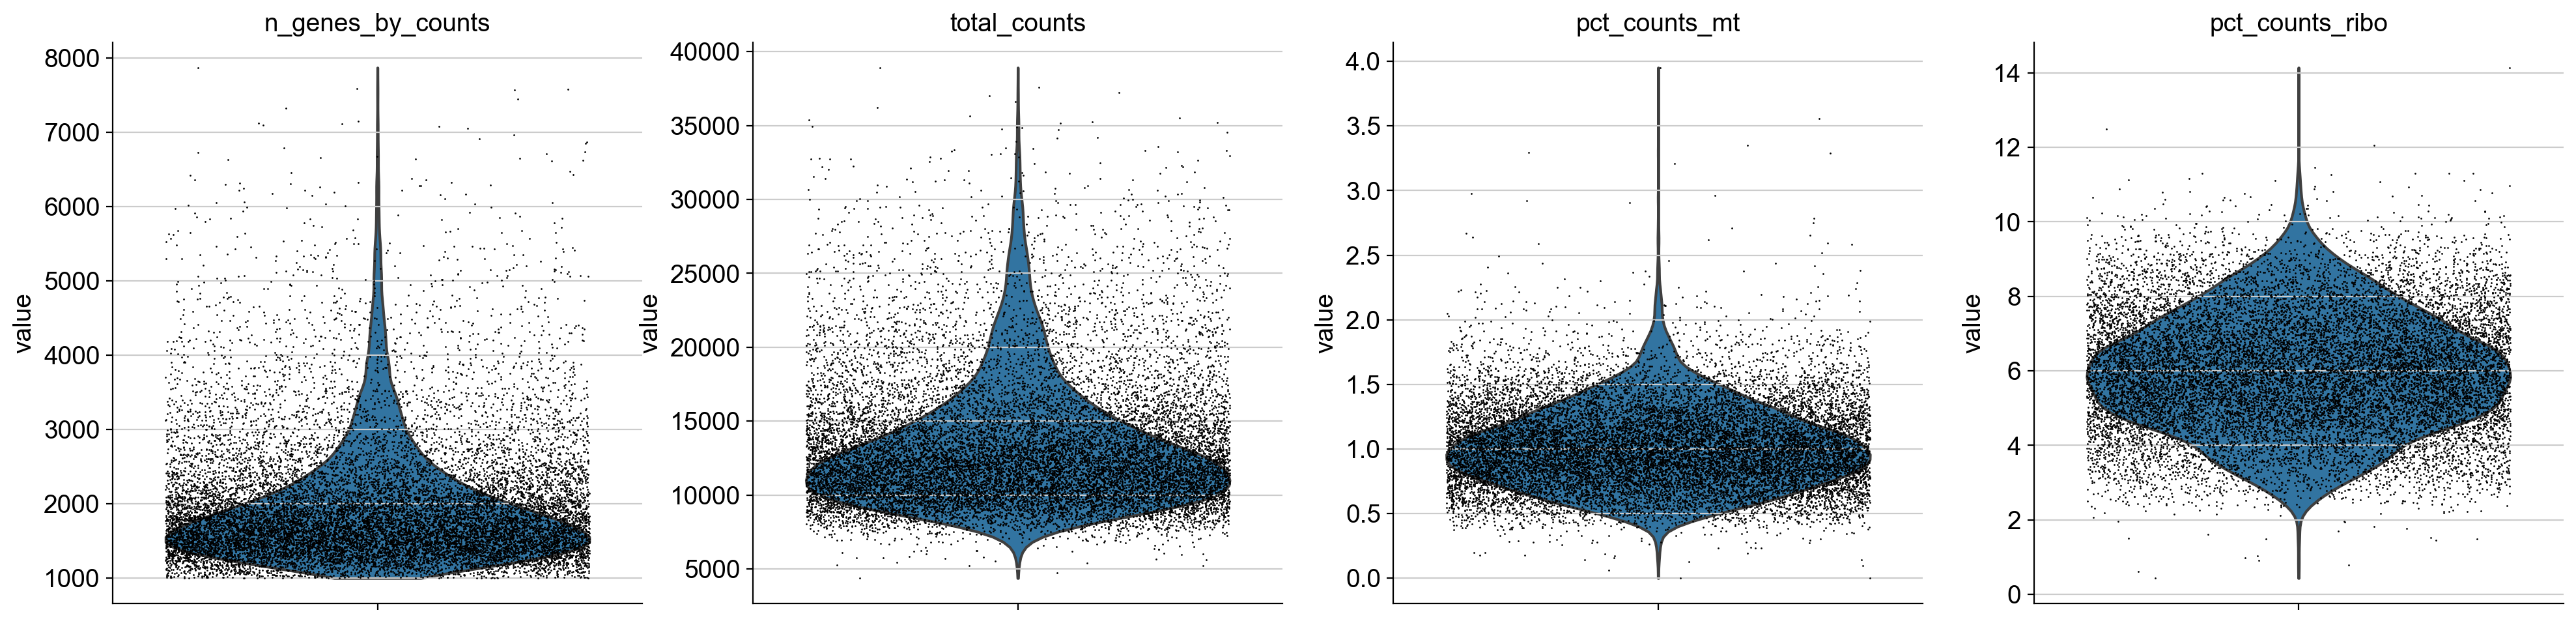

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 
                     'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [17]:
# if want to go back and remove the top 2% n_genes_by_counts

# upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
# print(upper_lim)

# # filter out cells that are above upper lim
# adata = adata[adata.obs.n_genes_by_counts < upper_lim]

## HVG: Highly variable gene calc

In [18]:
## HVG -- with 16K cells, setting HVG to ~1/3 of cells
sc.pp.highly_variable_genes(adata, n_top_genes = 5000)

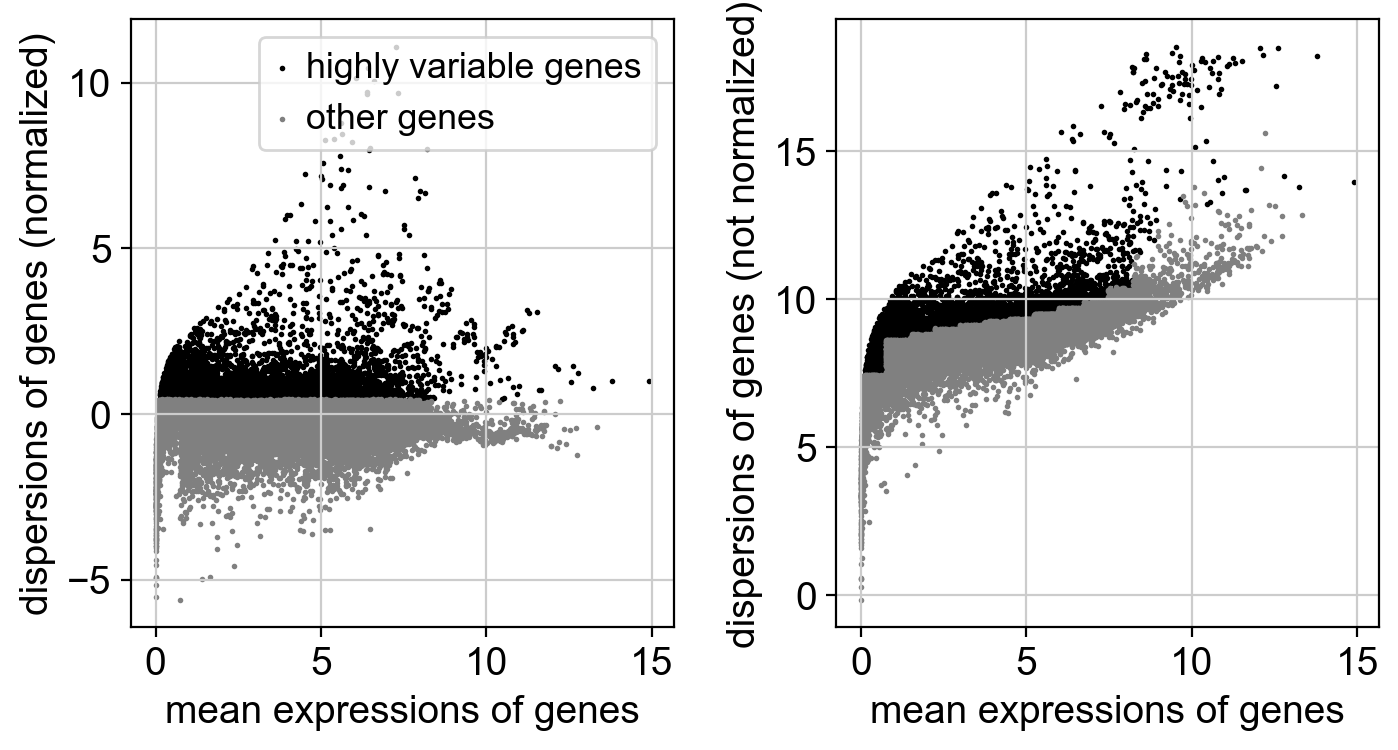

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
#filter down adata to HVG
HVG_data = adata.copy()
HVG_data.raw = HVG_data # freeze state of HVG_data by saving as raw attribute
HVG_data = HVG_data[:, HVG_data.var.highly_variable]
HVG_data

View of AnnData object with n_obs × n_vars = 16290 × 5000
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_filter_10cell_or_TPM12', 'protein_coding', 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [21]:
# rHVG_data = HVG_data.copy()

In [22]:
# sc.pp.regress_out(rHVG_data, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [45]:
# ############# 
# rpcHVG_data = rHVG_data.copy()
# #scale to unit variance for PCA, clip values exceding var 10
# sc.pp.scale(rpcHVG_data, max_value=10)
# # reduce the dimensionality of the data using PCA
# sc.tl.pca(rpcHVG_data, svd_solver='arpack')
# sc.pl.pca(rpcHVG_data, color='CD8A')

In [44]:
# sc.pl.pca_variance_ratio(rpcHVG_data, log=True, n_pcs = 50)

In [25]:
# #computing the neighborhood graph
# sc.pp.neighbors(rpcHVG_data, n_neighbors=10, n_pcs=40)

In [42]:
# #visualizing data with umap
# sc.tl.umap(rpcHVG_data)
# #visualize marker gene expression
# sc.pl.umap(rpcHVG_data, color=['CD19', 'NKG7', 'CD8A', 'pre_post_patinet_id'])

In [43]:
# sc.pl.umap(rpcHVG_data, color=['pre_post_patinet_id'])

In [ ]:
##############################################################

In [29]:
pcHVG_data = HVG_data.copy()
#scale to unit variance for PCA, clip values exceding var 10
sc.pp.scale(pcHVG_data, max_value=10)
# reduce the dimensionality of the data using PCA
sc.tl.pca(pcHVG_data, svd_solver='arpack')

In [30]:
#save the result
pcHVG_data.write(results_file)
#print
pcHVG_data

AnnData object with n_obs × n_vars = 16290 × 5000
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_filter_10cell_or_TPM12', 'protein_coding', 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

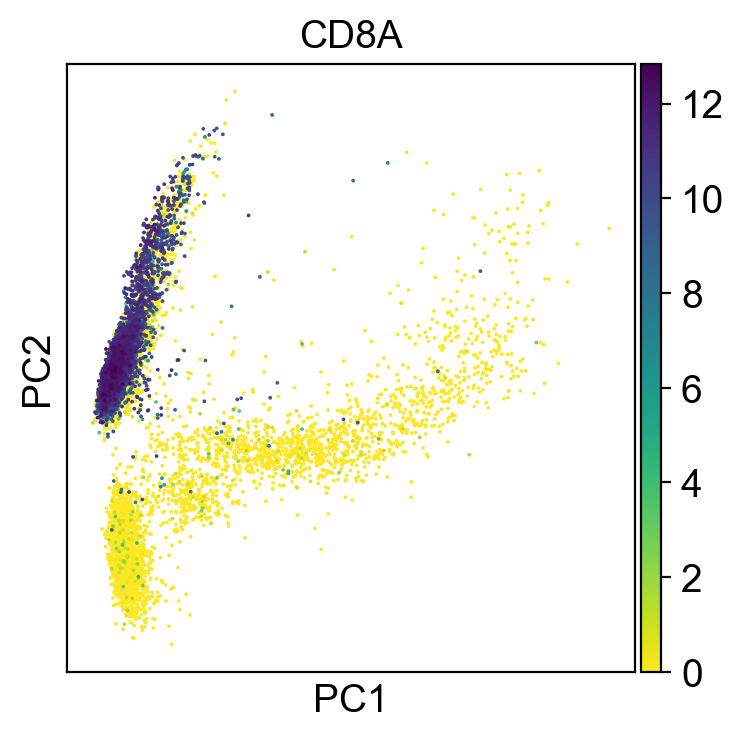

In [51]:
sc.pl.pca(pcHVG_data, color='CD8A')

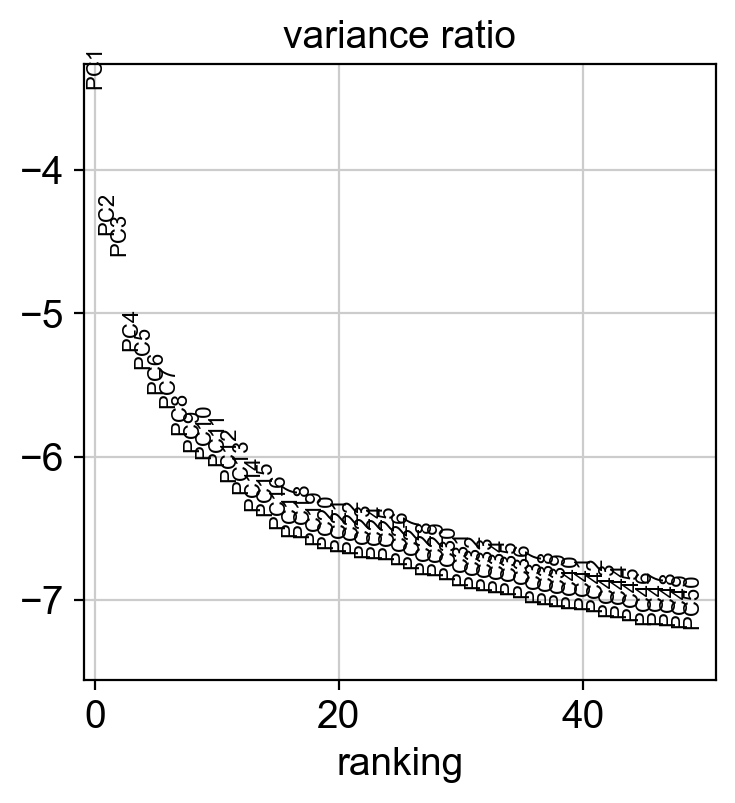

In [32]:
sc.pl.pca_variance_ratio(pcHVG_data, log=True, n_pcs = 50)

In [48]:
#plot the loadings, or the contribution of each gene to the PCs
# sc.pl.pca_loadings(pcHVG_data)

# Clustering

In [34]:
#computing the neighborhood graph
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=40)

In [35]:
#visualizing data with umap
sc.tl.umap(pcHVG_data)

In [135]:
# pcHVG_data

C:\Users\Romina\anaconda3\envs\scrnaseq\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


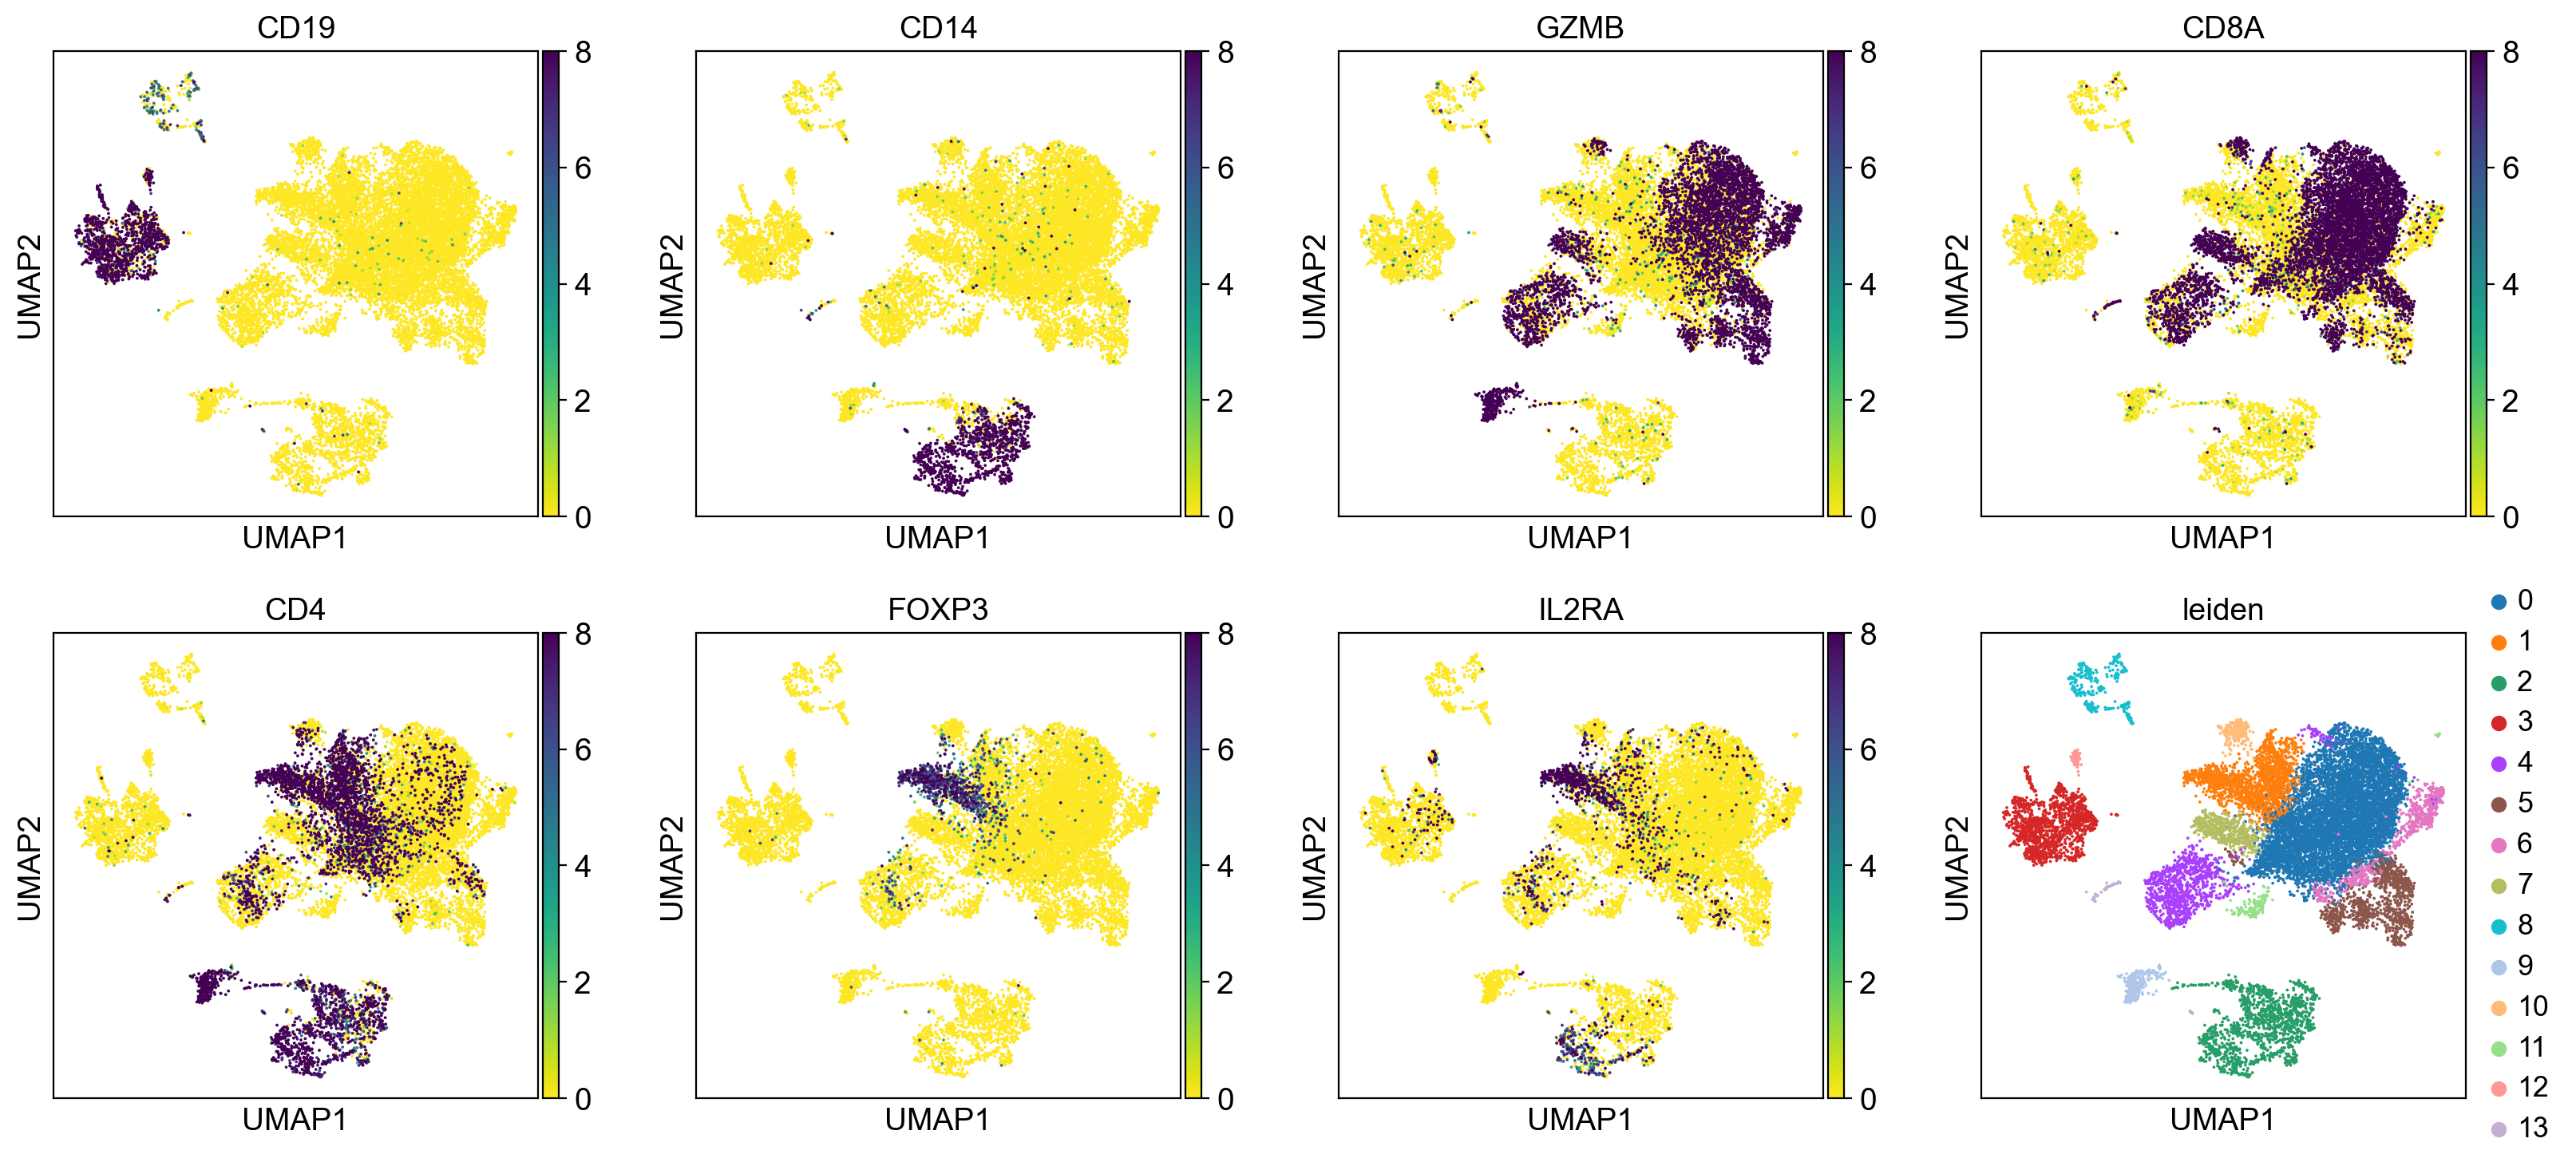

In [136]:
#visualize marker gene expression
sc.pl.umap(pcHVG_data, color=['CD19','CD14','GZMB','CD8A','CD4','FOXP3','IL2RA','leiden'], vmax=8)

In [137]:
sc.tl.rank_genes_groups(pcHVG_data, 'leiden')
# sc.pl.rank_genes_groups_heatmap(pcHVG_data, show_gene_labels=True, n_genes=5).T

In [138]:
# sc.pl.rank_genes_groups(pcHVG_data, n_genes=20, sharey=False)

In [139]:
markers = sc.get.rank_genes_groups_df(pcHVG_data, None)
markers = markers[(markers.pvals_adj < 0.5) & (markers.logfoldchanges > 0.5)]

In [140]:
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CCL5,66.396851,7.190494,0.000000,0.000000
1,0,CD8A,65.615143,6.950787,0.000000,0.000000
2,0,TRBC2,58.935120,5.136875,0.000000,0.000000
3,0,TRAC,52.522720,5.141213,0.000000,0.000000
4,0,CD3G,51.513439,4.539818,0.000000,0.000000
...,...,...,...,...,...,...
249418,13,DKFZP779L1853,1.014282,1.843224,0.315620,0.498616
249419,13,LEPR,1.013549,2.154267,0.315982,0.499049
249420,13,ZNF467,1.013535,1.888457,0.315983,0.499049
249421,13,RPL9,1.013318,0.607820,0.316072,0.499147


C:\Users\Romina\anaconda3\envs\scrnaseq\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


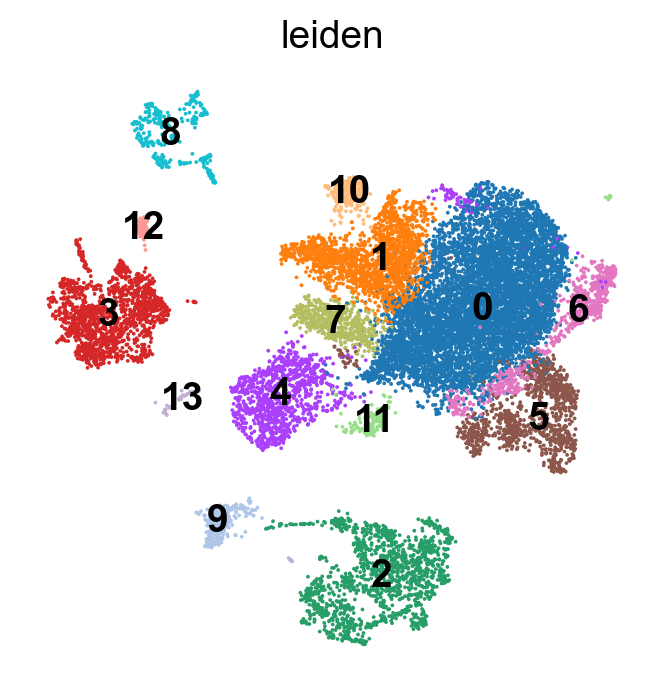

In [141]:
sc.pl.umap(pcHVG_data, color=['leiden'], frameon=False, legend_loc = "on data")

In [142]:
# #compute PAGA graph
# sc.tl.paga(pcHVG_data, groups='leiden')
# sc.pl.paga(pcHVG_data, color=['leiden', 'CST3', 'NKG7'])

In [143]:
# #recompute embedding using PAGA initialization
# sc.tl.draw_graph(pcHVG_data, init_pos='paga')
# sc.pl.draw_graph(pcHVG_data, color=['leiden', 'CST3', 'NKG7'], legend_loc='on data')

In [144]:
# pcHVG_data.obs

In [145]:
# sc.pl.umap(pcHVG_data, color=['response'])

In [146]:
# sanity check..
#scatter in the PCA coordinates of all genes

# sc.pp.scale(adata, max_value=10)
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='CD8A')
# sc.pl.pca_loadings(adata) 

In [147]:
## TSNE without HVG

In [151]:
# sc.tl.tsne(adata, perplexity=30, random_state=10)

In [149]:
# adata

AnnData object with n_obs × n_vars = 16290 × 18938
    obs: 'full_sample_name', 'title', 'pre_post_patinet_id', 'pre_post', 'patient_id', 'response', 'therapy', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_filter_10cell_or_TPM12', 'protein_coding', 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups', 'tsne'
    obsm: 'X_pca', 'X_tsne'

In [ ]:
# sc.pl.tsne(adata, color = ['patient_id'])

In [ ]:
# sc.tl.umap(adata)

In [ ]:
# dim,new_matrix,pc_ax,pc_ay,col_labels=PCA_Elbow_fit(pandas_data)
# print(dim)

In [105]:
cytokine_genes_dict = {
    'IL2R': ['IL2RA', 'IL2RB', 'IL2RG'],
    'IL10': ['IL10RA', 'IL10RB'],
    'IL12': ['IL12RB2']
}

In [106]:
tis_genes_dict = {
    'Antigen Presenting': ['PSMB10','CMKLR1'],
    'T cell/ NK cell': ['NKG7', 'CD8A'],
    'IFN Activity': ['CCL5', 'CXCL9', 'CD27', 'CXCR6','IDO1','STAT1'],
    'T Cell Exhaustion': ['TIGIT', 'LAG3', 'CD274','PDCD1LG2','CD276']
}
# excluding '['HLA-DQA1', 'HLA-DRB1', 'HLA-E']'

In [155]:
cell_genes_dict = {
    'CD3': ['CD3E'],
    'CD8': ['CD8A', 'CD8B'],
    'CD4 helper': ['CD4', 'IL7R'],
    'CD4 Treg': ['FOXP3', 'IL2RA','CTLA4'],
    'Monocytes': ['CD14','CD33','VCAN'],
    'B cells': ['CD19'],
    'Plasma cells': ['TNFRSF17','IGHG4','IGHG3'],
    'DCs': ['IL3RA', 'CLEC4C']
}

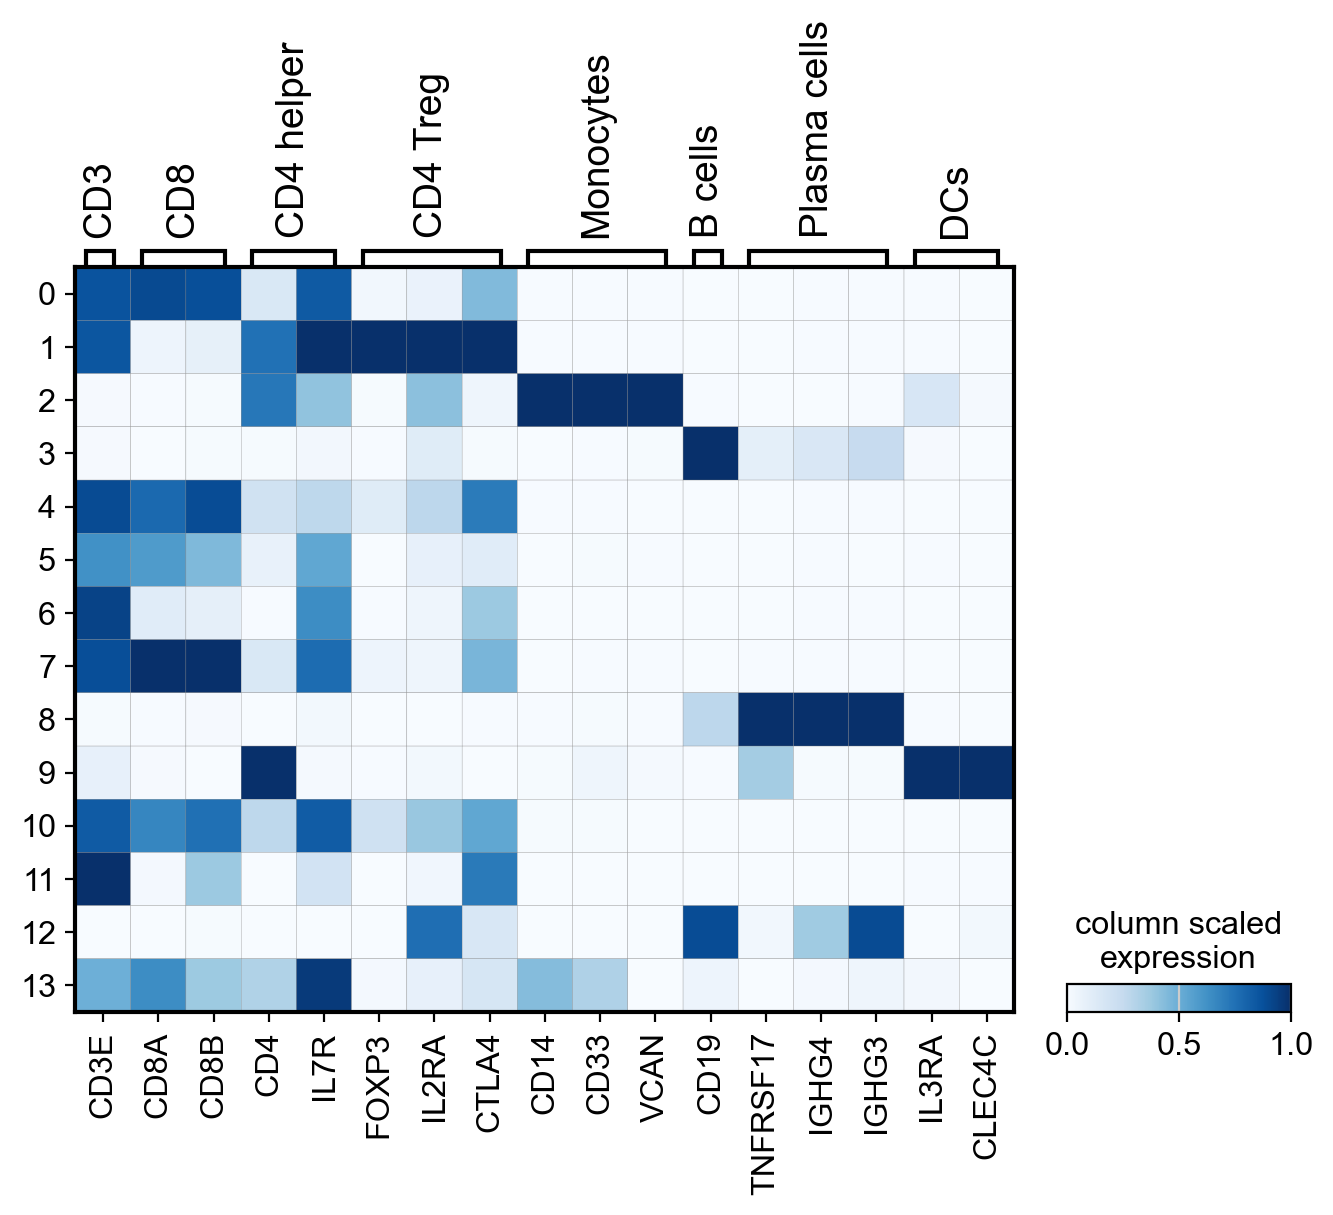

In [156]:
sc.pl.matrixplot(pcHVG_data, cell_genes_dict, 'leiden', cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')


In [107]:
gene1 = 'CD8B'
gene2 = 'CD3E'
gene3 = 'CD8A'

coex = ((pcHVG_adata.raw[:,'{}'.format(gene1)].X.todense() > 2) & (adata.raw[:,'{}'.format(gene2)].X.todense() > 2)) & (adata.raw[:,'{}'.format(gene3)].X.todense() > 2)

coex_list = [item for sublist in coex.tolist() for item in sublist]
adata.obs['CoEx'] = pd.Categorical(coex_list, categories=[True, False])

# adata.obs['CoEx'] = (adata.raw[:,'{}'.format(gene1)].X.todense() > 0) & (adata.raw[:,'{}'.format(gene2)].X.todense() > 0) 
#                     (adata.raw[:,'{}'.format(gene3)].X.todense() > 0)
adata.obs

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# # filter rows for year does not equal to 2002
# >gapminder_not_2002 = gapminder[gapminder['year']!=2002]
# >gapminder_not_2002.shape
# (1562, 6)


coexdata = adata.obs[adata.obs['CoEx']==True]
coexdata
coexdata.groupby("cell_type").count()

In [ ]:
sc.pl.umap(adata, color='CoEx', groups=[True])

In [ ]:
# with rc_context({'figure.figsize': (4.5, 3)}):
#     sc.pl.violin(adata, ['TIGIT', 'LAG3', 'CD274','PDCD1LG2','CD276'])

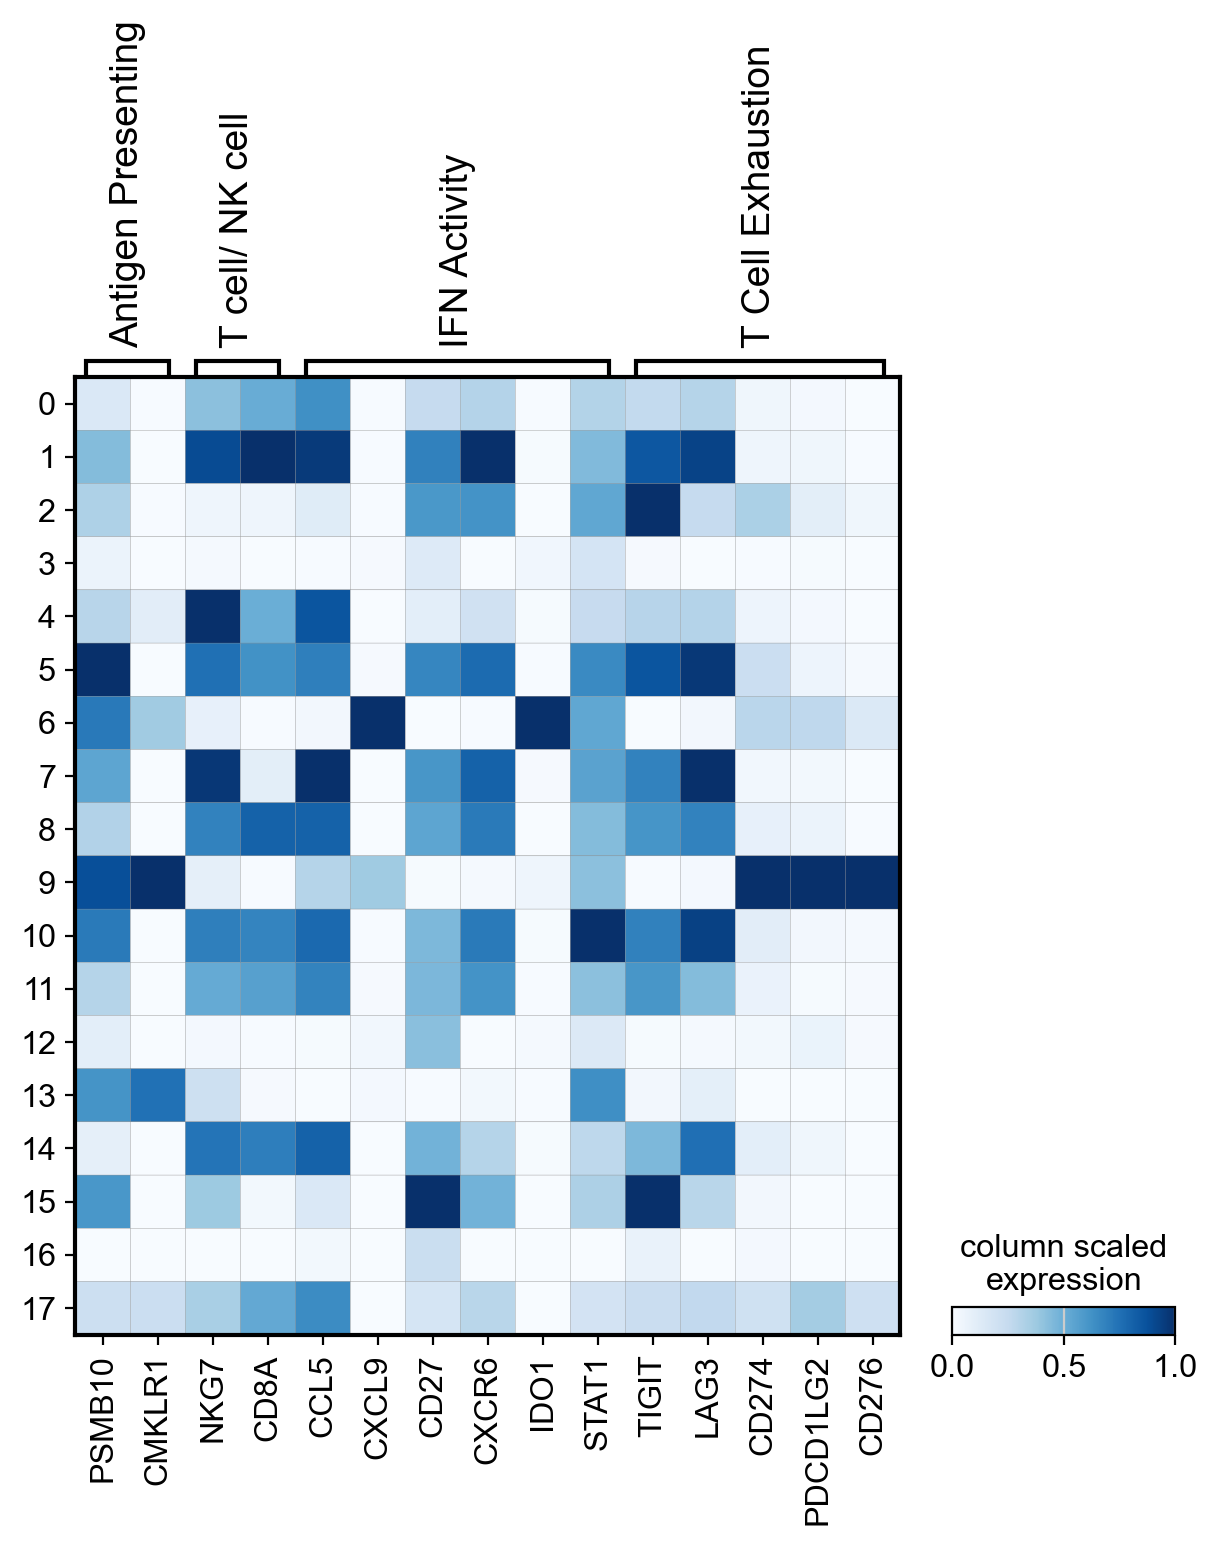

In [109]:
sc.pl.matrixplot(pcHVG_data, tis_genes_dict, 'leiden', dendrogram=False, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')


categories: 0, 1, 2, etc.
var_group_labels: IL2R, IL10, IL12


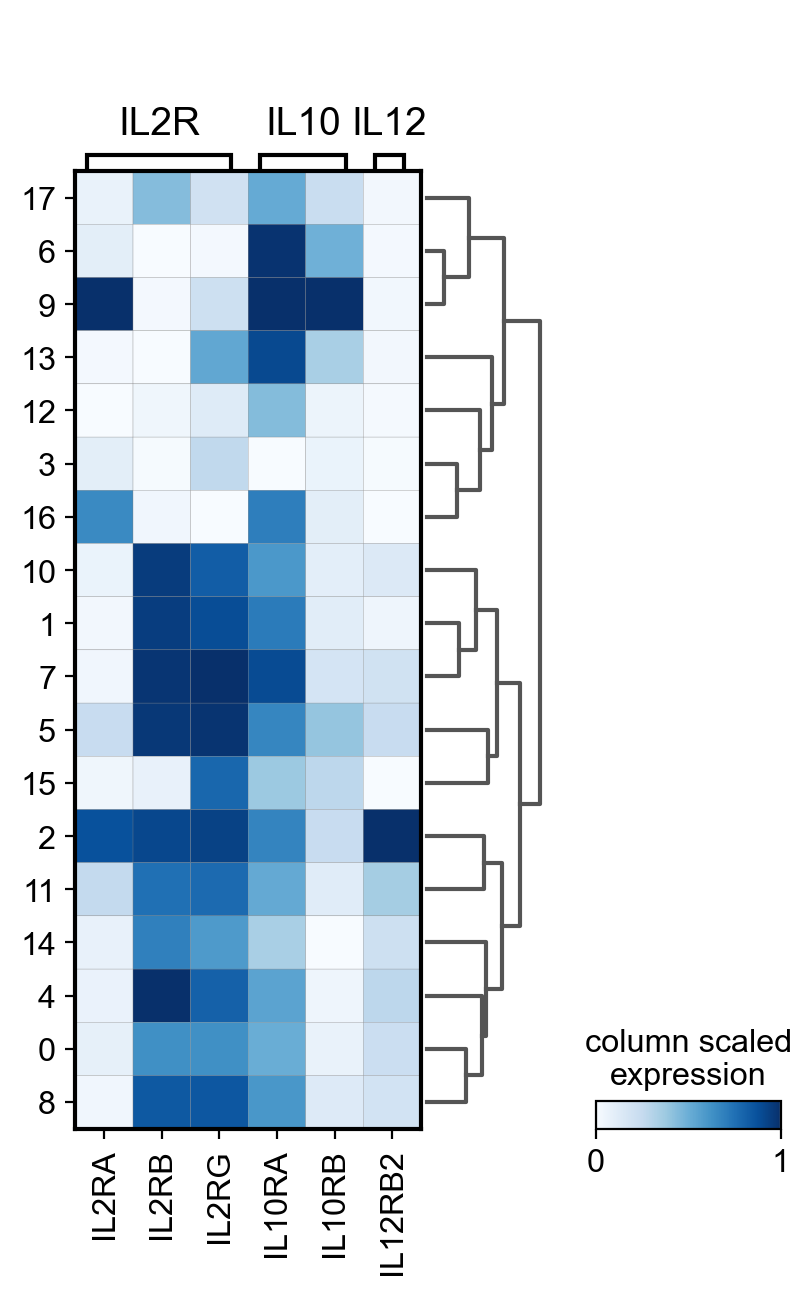

In [111]:
sc.pl.matrixplot(pcHVG_data, cytokine_genes_dict, 'leiden', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')


In [ ]:
# with rc_context({'figure.figsize': (4.5, 3)}):
# ax = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby = 'clusters')
ax = sc.pl.stacked_violin(adata, marker_genes_dict, groupby='cell_type', swap_axes=False, dendrogram=True)


In [ ]:
sc.pl.umap(adata, color = ['cell_type'], frameon = False)

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='cell_type', legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')